# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [103]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

df = pd.read_csv('data/human_body_temperature.csv')

## Helper functions:

In [104]:
def test_null_hypothesis(nulltext, pval, alpha):
    """test null hypothesis and print results"""
    if (pval < alpha):
        print('Result IS sig diff from H( %s )'%(nulltext))
    else:
        print('Result is NOT sig diff from H( %s )'%(nulltext))   
        
def bootstrap_replicate_1d(data, func):
    """datacamp func to draw one bootstrap replicate"""
    return func(np.random.choice(data, size=len(data)))

# datacamp func to draw bootstrap reps
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [105]:
# taking a quick descriptive look at the data
print(df.describe())

df.head()

       temperature  heart_rate
count   130.000000  130.000000
mean     98.249231   73.761538
std       0.733183    7.062077
min      96.300000   57.000000
25%      97.800000   69.000000
50%      98.300000   74.000000
75%      98.700000   79.000000
max     100.800000   89.000000


,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


### Is the distribution of body temperatures normal? 

Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.

Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test


Hist looks roughly normal...

Normality test: stat=2.704, pval=0.259
Result is NOT sig diff from H( is normally distributed )


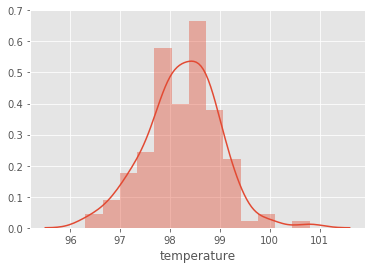

In [106]:
# plot a histogram as a visual normality check
sns.distplot(df['temperature']);

print('Hist looks roughly normal...')

# do a D’Agostino’s K^2 normality test:
from scipy.stats import normaltest

stat, pval = normaltest(df['temperature'])

print('\nNormality test: stat=%1.3f, pval=%1.3f'%(stat, pval))

# test the null hypothesis
test_null_hypothesis('is normally distributed', pval, .05)


### Is the sample size large? 
- Answer: The sample size is not small, <= 30 samples by the statistical definition of small. Not sure what formally defines "large", but if a sample that is not small is large, then this is large.

### Are the observations independent? 
- Answer: the data was [synthesized from a 1992 article](http://jse.amstat.org/v4n2/datasets.shoemaker.html). It is not stated that generated samples are independent, but we can probably assume this given the original data was independent.
    
Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.


## Is the true population mean really 98.6 degrees F?


### First, try a bootstrap hypothesis test.


In [107]:
# I will use a one sample bootstrap hypothesis test, 
#  with a null hypothesis that the mean is 98.6 F

# Make an array of translated temps
translated_temps = df['temperature'] - np.mean(df['temperature']) + 98.6

# Take bootstrap replicates of translated temps
bs_replicates = draw_bs_reps(translated_temps, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temp
pval = np.sum(bs_replicates <= np.mean(df['temperature'])) / 10000

# Print the p-value
print('Bootstrap pval = %1.9f'%(pval))

# test the null hypothesis
test_null_hypothesis('mean is 98.6 F', pval, .05)


Bootstrap pval = 0.000000000
Result IS sig diff from H( mean is 98.6 F )


### Now, let's try frequentist statistical testing. 

#### Would you use a one-sample or two-sample test? Why?
- Answer: this test would require a one sample t-test for a mean of 98.6 F, because there is only one sample to test from.

#### In this situation, is it appropriate to use the t or z statistic? 
- Answer: the population SD is not known, therefore a t-test is recommended.

#### Now try using the other test. How is the result different? Why?
- Answer: The result is not very different - in both cases the p-value is extremely small.


In [108]:
from scipy.stats import ttest_1samp
from scipy.stats import norm

# test the temps 
stat, pval = ttest_1samp(df['temperature'], 98.6)
 
print('\nt-test: stat=%1.3f, pval=%1.9f'%(stat, pval))

# test the null hypothesis
test_null_hypothesis('mean is 98.6 F', pval, .05)

# try using the other test
# using z-score method: z = (x – μ)*√n / σ 

# using sample sd as σ
z = ( (np.mean(df['temperature']) - 98.6) 
     * np.sqrt(len(df['temperature'])) 
     / np.std(df['temperature']) )

print('\nz-test: z-score=%1.3f, pval = %1.9f'%(z, norm.cdf(z)))

test_null_hypothesis('mean is 98.6 F', norm.cdf(z), .05)


t-test: stat=-5.455, pval=0.000000241
Result IS sig diff from H( mean is 98.6 F )

z-test: z-score=-5.476, pval = 0.000000022
Result IS sig diff from H( mean is 98.6 F )


### Draw a small sample of size 10 from the data and repeat both frequentist tests. 

#### Which one is the correct one to use? 
- Answer: t-test is recommended for sample sizes < 30

#### What do you notice? What does this tell you about the difference in application of the t and z statistic?
- Answer: The results are non-significant. After balancing the sampled data, the z-test usually reports a lower p value than the t-test. This suggests the z-test is a little more sensitive.

In [109]:
# separate male and female temperatures
males = df['temperature'][df['gender']=='M']
females = df['temperature'][df['gender']=='F']

# generate a  m/f balanced random subsample of temperatures:
pd.concat([males.sample(5),females.sample(5)])

subsample = df['temperature'].sample(10)

# test the temps 
stat, pval = ttest_1samp(subsample, 98.6)
 
print('\nt-test: stat=%1.3f, pval=%1.9f'%(stat, pval))

# test the null hypothesis
test_null_hypothesis('mean is 98.6 F', pval, .05)

# try using the other test
# using z-score method: z = (x – μ)*√n / σ 

# using sample sd as σ
z = ( (np.mean(subsample) - 98.6) 
     * np.sqrt(len(subsample)) 
     / np.std(subsample) )

print('\nz-test: z-score=%1.3f, pval = %1.9f'%(z, norm.cdf(z)))

test_null_hypothesis('mean is 98.6 F', norm.cdf(z), .05)


t-test: stat=-3.450, pval=0.007277499
Result IS sig diff from H( mean is 98.6 F )

z-test: z-score=-3.636, pval = 0.000138257
Result IS sig diff from H( mean is 98.6 F )


### At what temperature should we consider someone's temperature to be "abnormal"?

#### As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.

#### Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.


In [110]:
samp_mean = df['temperature'].mean()
samp_std = df['temperature'].std()
samp_n = len(df['temperature'])

# note: another way to get 95% CI:
# conf_int = norm.interval(0.95, loc=samp_mean, scale=samp_std/np.sqrt(samp_n))

# MOE at 95% CI = z(95%) * sd / sqrt(n)
moe = 1.96 * samp_std / np.sqrt(samp_n)
print('frequentist method:')
print('Mean +/- MOE = %2.3f +/- %1.3f'%(samp_mean, moe))

print('95% CI =',samp_mean-moe,samp_mean+moe)

# using the bootstrap approach:
print('\nbootstrap method: ')

bs_replicates = draw_bs_reps(df['temperature'],np.mean,10000)

norm.interval(0.95, loc=np.mean(bs_replicates), 
              scale=np.std(bs_replicates))

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates,[2.5,97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'F')



frequentist method:
Mean +/- MOE = 98.249 +/- 0.126
95% CI = 98.12319411222849 98.37526742623301

bootstrap method: 
95% confidence interval = [98.12230769 98.37384615] F


### Is there a significant difference between males and females in normal temperature?
- Answer: yes, there is a significant difference: men have lower body temperatures.

#### What testing approach did you use and why?
- Answer: I used an two sample t-test for independent samples. This the correct test for these data, and is simpler than bootstrap methods.



In [111]:
# using a two sample unpaired (independent) t-test
from scipy.stats import ttest_ind

males = df['temperature'][df['gender']=='M']
females = df['temperature'][df['gender']=='F']

stat, pval = ttest_ind(males,females)

print('mean body temps: men=%1.3f, women=%1.3f'%(males.mean(), females.mean()))

print('\ntwo sample unpaired t-test: t=%1.3f, pval=%1.3f'%(stat,pval))
test_null_hypothesis('Men and women have same body temp', pval, .05)

mean body temps: men=98.105, women=98.394

two sample unpaired t-test: t=-2.285, pval=0.024
Result IS sig diff from H( Men and women have same body temp )


#### Write a story with your conclusion in the context of the original problem.

The results of these tests provide strong to refute the prevailing belief that the human body temperature is 98.6F. Based on these sample measurements, the actual mean body temperature is closer to 98.3F. Furthermore, male and female body temperatures were found to be significantly different (98.1F vs 98.4F for men and women, respectively). 